In [286]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Explanary Notes:

This is a plotter for results plotting of Monotonic Shear Experiments & Elastic Moduli Experiments. 
<br>
File name conventions are as explained below: <br>
E.g.: MS_100C <br>
1) MS: Monotonic Shear <br>
2) 100: Applied Vertical Effective Stress <br>
3) C or S: Consolidation or Shear <br>
<br>
E.g.: EM1_C_100 <br>
1) EM1: Elastic modulus, Stage 1 <br>
2) C/BM/YM: Consolidation/Bulk Modulus/Young's Modulus <br>
3) 100: Applied Vertical Effective Stress <br>


In [287]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [288]:
%matplotlib notebook
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import pandas as pd
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
from matplotlib import rc
from matplotlib import ticker
import os

matplotlib.rcParams.update({'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [289]:
def on_test_type_change(*args):
    test_type = radio_btn_test_type.value    
    if radio_btn_test_type.value == 'Elastic Moduli':
        seclected_test.options = test_EM
    else:
        seclected_test.options = test_MS
        
def update_plot(*args):
    clear_output()
    plt.close("all")
    plot_all(test_type = radio_btn_test_type.value, seclected_test = seclected_test.value)

In [290]:
# reading initial void ratio information from csv
initial_void_ratio = pd.read_csv("Initial Void ratios.csv")
initial_void_ratio.columns = ['','test at p','e_initial']
all_vertical_stress = initial_void_ratio.loc[:,'test at p'].tolist()
all_e_initial = initial_void_ratio.loc[:,'e_initial'].tolist()
avg_e = round(float(np.average(all_e_initial)), 3)

In [291]:
# Reading file names wrt categories
# not reading all test files here, 
# reading based on only EM and MS, future added new name needs edition
dir_root = os.getcwd()
files = os.listdir(dir_root)

# get unique value for EM test cases
original_EM = [f for f in files if f.startswith("EM")]
original_MS = [f for f in files if f.startswith("MS")]

new_EM = []
for i in range(0,len(original_EM)):
    new_EM.append(original_EM[i].split('_')[0])
test_EM = sorted(list(set(new_EM)))
test_MS = []
for i in range(0,len(original_MS)):
    test_MS.append(original_MS[i].split('.')[0])

p_max = int(test_MS[-1].split('_')[1][:3])


In [292]:
##### find void ratio values for EM cases and sort files into dictionary #####
# number of stage
no_stage = len(test_EM)
# group all files by category
consolidation = []
bulk_modu = []
youngs_modu = []
for i in range(len(original_EM)):
    if 'C' in original_EM[i]:
        consolidation.append(original_EM[i])
    if 'BM' in original_EM[i]:
        bulk_modu.append(original_EM[i])
    if 'YM' in original_EM[i]:
        youngs_modu.append(original_EM[i])   

# prepare dictionary for all types of files
stages = {}
BM = {}
YM = {}
for i in range(no_stage):
    key = 'stage'+str(i)
    key_bm = 'stage_bm'+str(i)
    key_ym = 'stage_ym'+str(i)
    stages[key] = pd.read_csv(consolidation[i])[1:].astype(float)
    BM[key_bm] = pd.read_csv(bulk_modu[i])[1:].astype(float)
    YM[key_ym] = pd.read_csv(youngs_modu[i])[1:].astype(float)

# calculate void ratios for all stages    
e0 = avg_e
for key in stages:
    stages[key]['delta_e'] = stages[key]['Ev - Volumetric Strain'][1:]/((1+e0)*100)
    stages[key]['e_final'] = e0 - stages[key]['delta_e']
    e0 = stages[key]['e_final'].iloc[-1]
    

<IPython.core.display.Javascript object>


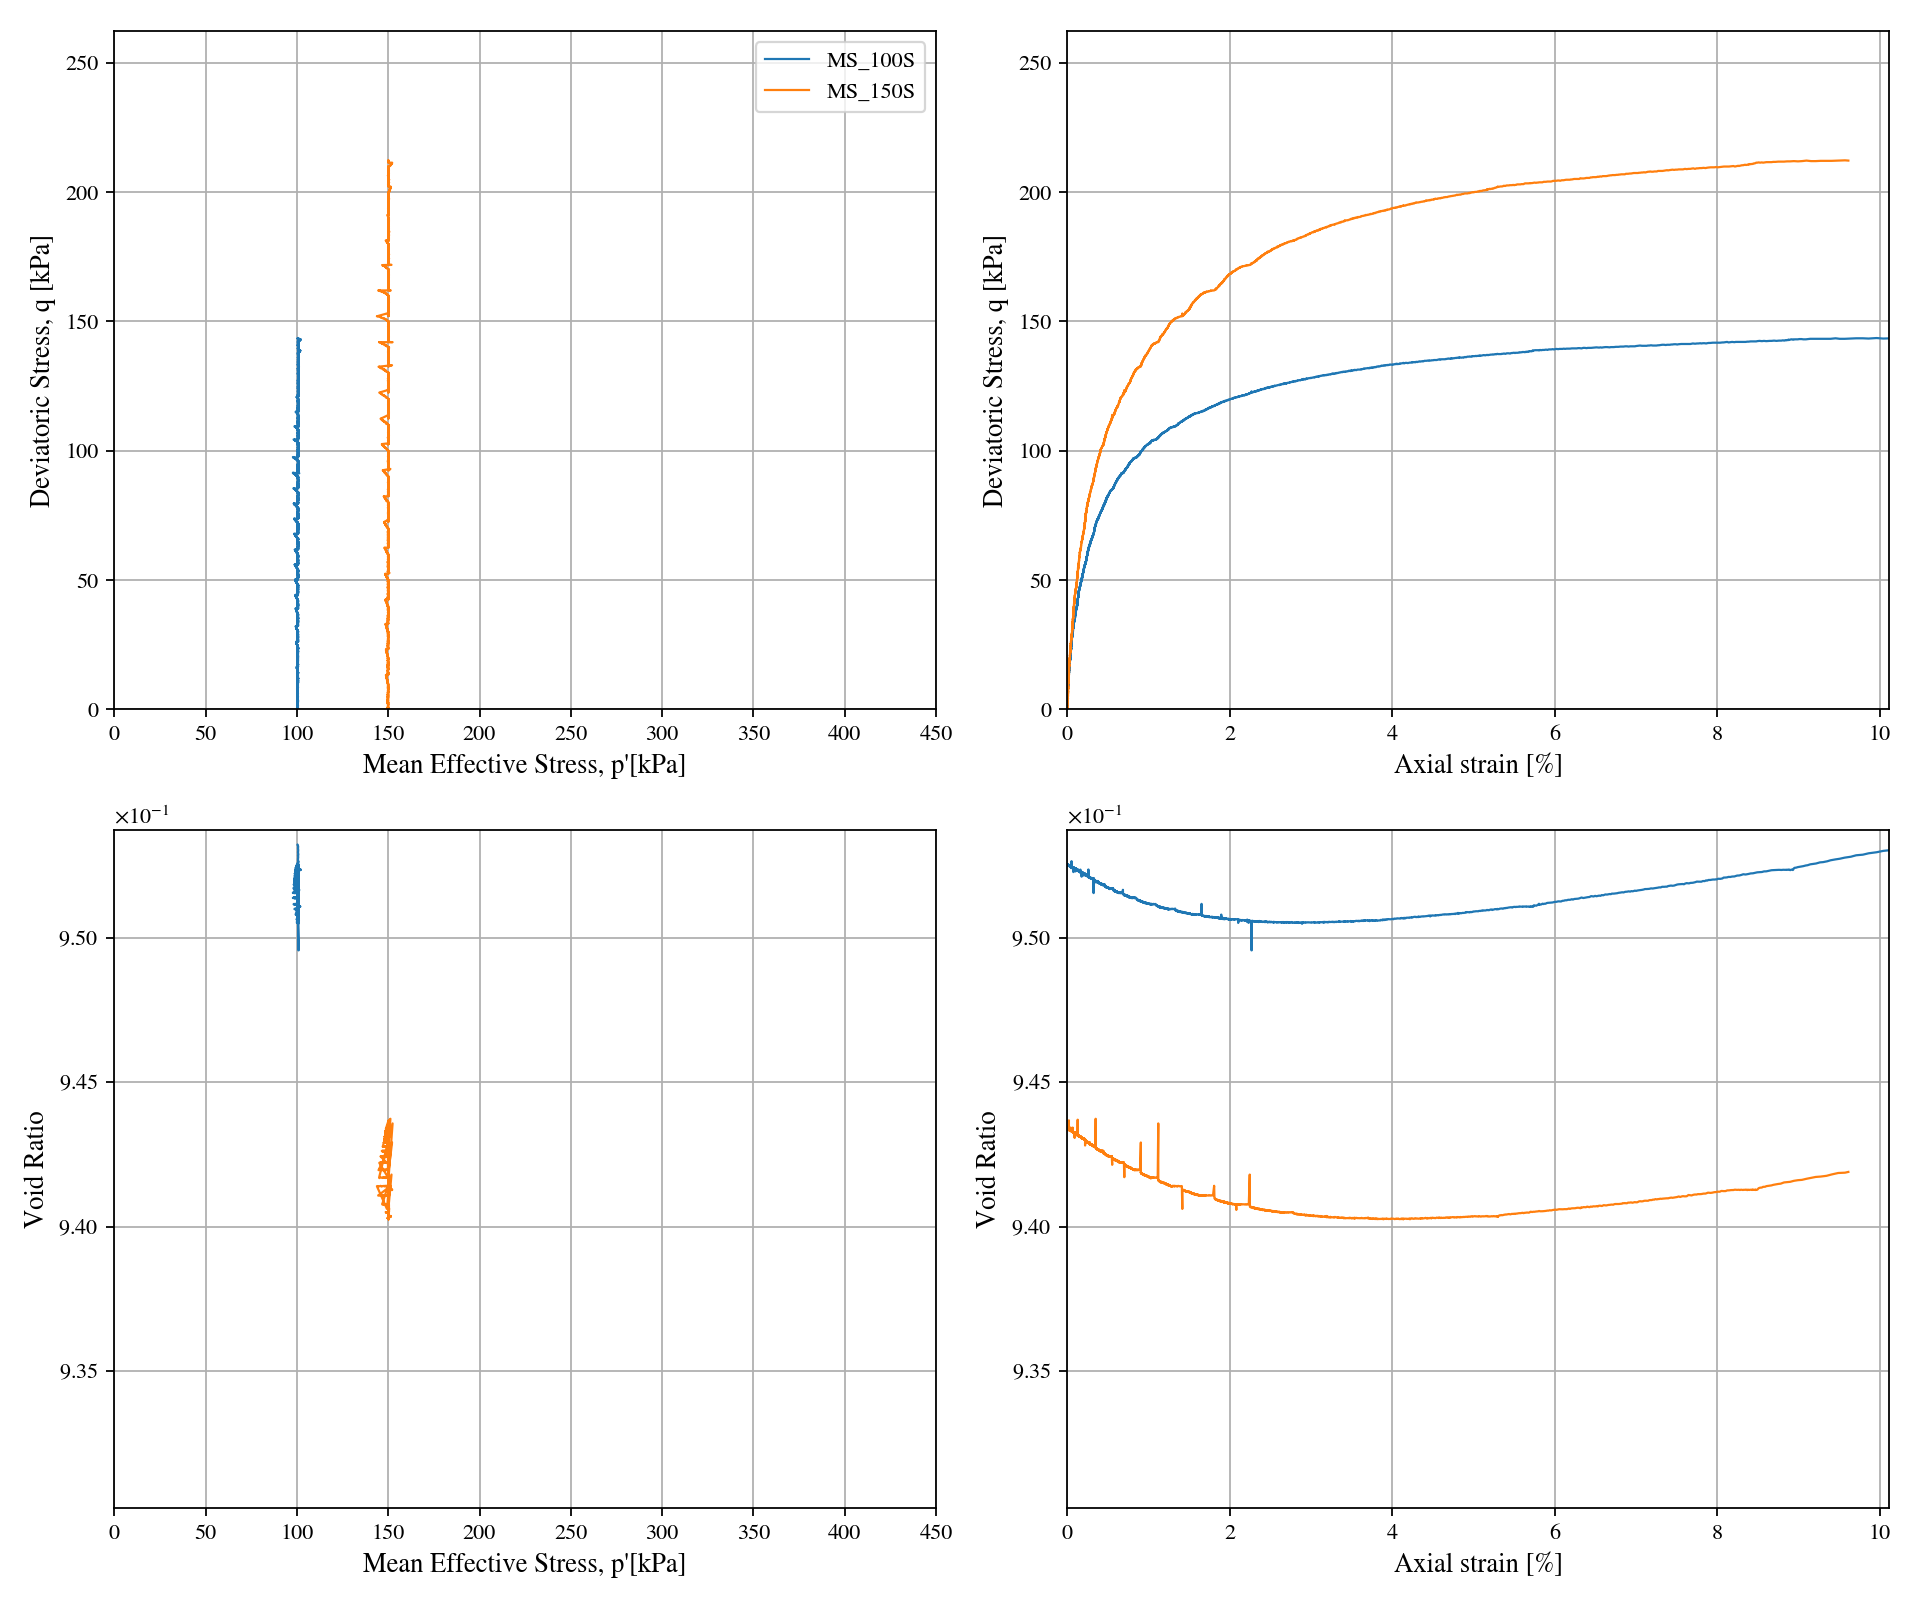

In [293]:
def plot_all(test_type, seclected_test):
    # set formats of layout
    font = {'color':  'black',
        'weight': 'normal',
        'size': 12,
        }
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1))
    
    # extract selected tests
    test_chose = list(seclected_test)
    L = len(test_chose)
    
    if test_type == 'General 7 Triaxial':
        if L>0:
            f, axes = plt.subplots(2,2,figsize=(12,10),dpi=80)
            
            for i in range(0,L):
                name = test_chose[i]
                con_or_shear = list(name)[-1]
                vertical_stress = int(name.split('_')[-1][:3])
                # find initial void ratio from csv
                find_e = initial_void_ratio.loc[initial_void_ratio['test at p'] == int(vertical_stress)]
                e_initial = find_e.loc[:,'e_initial'].tolist()[0]
                data = pd.read_csv(name + '.csv')[1:].astype(float)
                # create label for plots
                label = test_chose[i]  
                
                if con_or_shear == 'C':
                    # compute a new void ratio column in dataframe
                    data['delta_e'] = data['Ev - Volumetric Strain'][1:]/((1+e_initial)*100)
                    data['e_final'] = e_initial - data['delta_e']
                
                    # Start plotting
                    axes[0,0].plot(data['Time'][1:], data['p\' Cambridge Mohr Effective Stress'][1:],
                                  linewidth=1, label=label)
                    axes[0,0].set_xlabel('Time [s]',fontdict=font)
                    axes[0,0].set_ylabel('Cambridge Mohr Effective Stress [kPa]',fontdict=font)
                    axes[0,0].set_xlim([0,max(data['Time'][1:])+5])
                    axes[0,0].legend(loc='best',prop={'size':10})
                    axes[0,0].grid(True)
                    f.tight_layout()
                    
                    axes[1,0].plot(data['Time'][1:], data['Ev - Volumetric Strain'][1:],
                                  linewidth=1)
                    axes[1,0].set_xlabel('Time [s]',fontdict=font)
                    axes[1,0].set_ylabel('Ev - Volumetric Strain [%]',fontdict=font)
                    axes[1,0].set_xlim([0,max(data['Time'][1:])+5])
                    axes[1,0].grid(True)
                    f.tight_layout()
                    
                    axes[0,1].plot(data['p\' Cambridge Mohr Effective Stress'][1:], data['e_final'][1:],
                                  linewidth=1)
                    axes[0,1].set_xlabel('Cambridge Mohr Effective Stress [kPa]',fontdict=font)
                    axes[0,1].set_ylabel('Void Ratio',fontdict=font)
                    axes[0,1].yaxis.set_major_formatter(formatter)
                    axes[0,1].grid(True)
                    f.tight_layout()
                    
                    axes[1,1].axis('off')
                
                if con_or_shear == 'S':
                    # get initial void ratio for shear stage
                    name_for_e = 'C'.join(name.rsplit('S',1))
                    data_for_e = pd.read_csv(name_for_e + '.csv')[1:].astype(float)
                    data_for_e['delta_e'] = data_for_e['Ev - Volumetric Strain'][1:]/((1+e_initial)*100)
                    data_for_e['e_final'] = e_initial - data_for_e['delta_e']
                    e_initial_shear = data_for_e['e_final'].iloc[-1]
                    
                    # compute a new void ratio column in dataframe
                    data['delta_e'] = data['Ev - Volumetric Strain'][1:]/((1+e_initial_shear)*100)
                    data['e_final'] = e_initial_shear - data['delta_e']
                    
                    # Start plotting
                    axes[0,0].plot(data['p\' Cambridge Mohr Effective Stress'][1:], data['Sd - Deviator Stress'][1:],
                                   linewidth=1, label=label)
                    axes[0,0].set_xlabel('Mean Effective Stress, p\'[kPa]',fontdict=font)
                    axes[0,0].set_ylabel('Deviatoric Stress, q [kPa]',fontdict=font)
                    axes[0,0].legend(loc='best',prop={'size':10}) 
                    axes[0,0].set_xlim([0,p_max+50])
                    axes[0,0].set_ylim([0,max(data['Sd - Deviator Stress'][1:])+50])
                    axes[0,0].grid(True)
                    f.tight_layout()
                    
                    axes[0,1].plot(data['Ea - Axial Strain'][1:], data['Sd - Deviator Stress'][1:], 
                                  linewidth=1, label=label)
                    axes[0,1].set_xlabel('Axial strain [%]',fontdict=font)
                    axes[0,1].set_ylabel('Deviatoric Stress, q [kPa]',fontdict=font)
                    axes[0,1].set_xlim([0,max(data['Ea - Axial Strain'][1:])+0.5])
                    axes[0,1].set_ylim([0,max(data['Sd - Deviator Stress'][1:])+50])
                    axes[0,1].grid(True)
                    f.tight_layout()
                    
                    axes[1,0].plot(data['p\' Cambridge Mohr Effective Stress'][1:], data['e_final'][1:],
                                  linewidth=1, label=label)
                    axes[1,0].set_xlabel('Mean Effective Stress, p\'[kPa]',fontdict=font)
                    axes[1,0].set_ylabel('Void Ratio',fontdict=font)
                    axes[1,0].set_xlim([0,p_max+50])
                    axes[1,0].set_ylim([min(data['e_final'][1:])-0.01,max(data['e_final'][1:])+0.01])
                    axes[1,0].yaxis.set_major_formatter(formatter)
                    axes[1,0].grid(True)
                    f.tight_layout()
                    
                    axes[1,1].plot(data['Ea - Axial Strain'][1:], data['e_final'][1:],
                                  linewidth=1, label=label)
                    axes[1,1].set_xlabel('Axial strain [%]',fontdict=font)
                    axes[1,1].set_ylabel('Void Ratio',fontdict=font)
                    axes[1,1].set_xlim([0,max(data['Ea - Axial Strain'][1:])+0.5])
                    axes[1,1].set_ylim([min(data['e_final'][1:])-0.01,max(data['e_final'][1:])+0.01])
                    axes[1,1].yaxis.set_major_formatter(formatter)
                    axes[1,1].grid(True)
                    f.tight_layout()
    
    if test_type == 'Elastic Moduli':
        if L>0:
            f, axes = plt.subplots(2,2,figsize=(10,10),dpi=80)
            
            for i in range(0,L):
                name = test_chose[i]
                number = list(name)[-1]
                key = 'stage' + str(int(number)-1)
                key_bm = 'stage_bm' + str(int(number)-1)
                key_ym = 'stage_ym' + str(int(number)-1)
                consolidation = stages[key]
                bulk_modulus = BM[key_bm]
                youngs_modulus = YM[key_ym]
                label = 'Stage ' + number
                
                # Start plotting
                axes[0,0].plot(consolidation['p\' Cambridge Mohr Effective Stress'][1:], consolidation['e_final'][1:],
                              linewidth=1, label=label)
                axes[0,0].set_xlabel('Mean effective stress [kPa]',fontdict=font)
                axes[0,0].set_ylabel('Void ratio, e',fontdict=font)
                axes[0,0].set_title('CONSOLIDATION',fontdict=font)
                axes[0,0].yaxis.set_major_formatter(formatter)
                axes[0,0].legend(loc='best',prop={'size':10})
                axes[0,0].grid(True)
                f.tight_layout()

                axes[0,1].plot(bulk_modulus['Ev - Volumetric Strain'][1:], 
                               bulk_modulus['p\' Cambridge Mohr Effective Stress'][1:],
                              linewidth=1, label=label)
                axes[0,1].set_xlabel('Volumetric strain [%]',fontdict=font)
                axes[0,1].set_ylabel('Mean effective stress [kPa]',fontdict=font)
                axes[0,1].set_title('BULK MODULUS',fontdict=font)
                axes[0,1].grid(True)
                f.tight_layout()
                
                axes[1,0].plot(youngs_modulus['Ea - Axial Strain'][1:], youngs_modulus['Sd - Deviator Stress'][1:],
                              linewidth=1, label=label)
                axes[1,0].set_xlabel('Axial strain [%]',fontdict=font)
                axes[1,0].set_ylabel('Deviator stress [kPa]',fontdict=font)
                axes[1,0].set_title('YOUNG\'S MODULUS',fontdict=font)
                axes[1,0].xaxis.set_major_formatter(formatter)
                axes[1,0].grid(True)
                f.tight_layout()

                axes[1,1].axis('off')
                
# Initiate widgets                
radio_btn_test_type = widgets.RadioButtons(options=['General 7 Triaxial','Elastic Moduli'],
                             description='Test Type',variable=[True,False])

seclected_test = widgets.SelectMultiple(description="Test Cases", options= [])

# set a default value for selected test
seclected_test.options = test_MS
radio_btn_test_type.observe(on_test_type_change, names="value")
seclected_test.observe(update_plot, names="value")

hbox_param_major = widgets.HBox([radio_btn_test_type],
                                layout = Layout(display='flex',flex_flow='row',
                                                align_items='stretch', width='100%',height="50%"))

vbox_test = widgets.VBox([seclected_test],
                         layout = Layout(overflow_y = "scroll", display='flex',flex_flow='row', 
                                         align_items='stretch', width="50%")) 

display(hbox_param_major)
display(vbox_test)